# Calculate KS Statistic on Real and Gaussian Data
In this notebook, it is possible to perform a KS statistic test between gaussian noise and real data power spectrums. It is also possible to compare between using Pspec and calculating manually the power spectrum.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gspec
from scipy.optimize import curve_fit
import math
from matplotlib.ticker import MaxNLocator

In [2]:
def Simulated_Gaussian_Noise(sigma,mu):
    
    for time in range(0,60):
        if time == 0:
            visibility_data = np.random.normal(mu,sigma,1024)
        else:
            noise = np.random.normal(mu,sigma,1024)
        if time != 0:
            visibility_data = np.vstack((visibility_data,noise))
    
    return visibility_data

In [71]:
def Pspec_Data(baseline,fmin,n_dly,data_quantity,pol):
    
    # Set up the key for the power spectrum data
    key=(0,(baseline,baseline),pol)

    power = []
    spw_range = []
    delay_index_range = []
    
    #num_delays = np.min(data_quantity)
    # The -2 is there to avoid generating power spectrums where the spw range is too small.
    for num in data_quantity:
        
        
        uvp = ds.pspec([baseline], [baseline], (0, 1), [(pol, pol)],spw_ranges=[(fmin,fmin+num)],exact_norm=False,n_dlys = None,norm = 'I',input_data_weight='identity', taper='blackman-harris', verbose=False)
        
        # We calculate the size of the spectral window depending on the number of iterations
        n_dly=num
        power.append(np.abs(np.real(uvp.get_data(key))))
        
        spw_range.append('('+str(int(uvd.freq_array[0,fmin]/1e4)/100)+'-'+str(int(uvd.freq_array[0,fmin+num]/1e4)/100)+')')
        delay_index_range.append([int(2*(n_dly)/3),n_dly])
    # We return the data as a list containings lists.
    return power,delay_index_range,spw_range

In [68]:
def Direct_Data(fmin,vis_data,data_quantity):

    power = []
    
    for num in data_quantity:
        delay_data = np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis_data[:,fmin:fmin+num],axes=1),axis=1),axes=1)
        k = np.trapz(uvb.power_beam_sq_int('XX')/(uvb.power_beam_int('XX')**2),uvb.beam_freqs)/((num*(uvb.beam_freqs[1]-uvb.beam_freqs[0]))**2)
        #delay_real = np.fft.fftshift(np.fft.fft(np.fft.fftshift(real_data[:,fmin:fmin+num],axes=1),axis=1),axes=1)
        odd_v = delay_data[::2,:]
        even_v = delay_data[1::2,:]
        
        if odd_v.shape[0] != even_v.shape[0]:
            print(odd_v.shape[0],even_v.shape[0])
            if odd_v.shape[0] > even_v.shape[0]:
                odd_v = odd_v[0:-1,:]
            else:
                even_v = even_v[0:-1,:]
        #power.append(np.abs(even_v[:,int(2*num/3):num])*np.abs(odd_v[:,int(2*num/3):num])/(k*num**2))
        power.append(np.abs(even_v)*np.abs(odd_v)/(k*num**2))

    return power

In [64]:
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm, kstest
def plot_kstest(x, data, x_delay=False, alpha=0.05):
    """
    H0: dist1 = dist2
    d < critical value, p-value > alpha -->> accept H0
    ------
    x: 1d array (time, delay mode)
    data: 2d array (visibility, power)
    x_delay: is x axis delay? (default: False)
    alpha: significance level (default: 0.05)
    ------
    Data matrix rows -->> time sample
    Data matrix columns -->> frequency/delay mode
    """
    
    if x_delay:
        data = np.transpose(data)
    
    # fit each dataset with a normal distribution
    mu = []
    std = []
    for d in data:
        mu.append(norm.fit(d)[0])
        std.append(norm.fit(d)[1])
        
        
    # get cdf of each dataset
    cdf = []
    for d in data:
        cdf.append(np.array(range(len(d)))/float(len(d)))
    
    # get cdf of each fit
    norm_cdf = []
    for d,m,s in zip(data,mu,std):
        norm_cdf.append(norm.cdf(np.sort(d), m, s))
    
    # perform KS test between each empirical dataset with its corresponding normal distribution
    # get d (KS statistic) and p-values
    d = []
    p = []
    for i in range(len(data)):
        d.append(stats.ks_2samp(cdf[i], norm_cdf[i])[0])
        p.append(stats.ks_2samp(cdf[i], norm_cdf[i])[1])
    
    # get critical value (significance level = 0.05) (by the AD-test function)
    cv = []
    for i in range(len(data)):
        cv.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1][2])
    
    # plot cdf if the number of datasets is small
    #if len(data) < 16:
        #plt.figure(figsize=(12, 12))
        #for i in range(1, len(cv)+1):
            #plt.subplot(6, 4, i)
            #i -= 1
            #plt.plot(np.sort(data[i]), norm_cdf[i],'b--')
            #plt.plot(np.sort(data[i]), cdf[i], 'r-')
            #plt.grid()
    
    # plot KS test results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot
    ax.plot(x, d, 'r-', label='KS statistics')
    ax.plot
    ax.plot(x, cv, 'b--', label='Critical values')
    ax.grid()
    ax.legend()
    
    plt.subplot(2, 1, 1)
    plt.plot(x, [alpha for i in range(len(x))], 'k--', label='Significance level')
    plt.plot(x, p, 'g-', label="p values")
    plt.legend()
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(x, cv, 'b--', label='Critical values')
    plt.plot(x, d, 'r-', label='KS statistics')
    plt.legend()
    plt.grid()
    plt.show()

In [89]:
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm, kstest
def plot_2datasamples_kstest(x, data1, data2, x_delay=False, alpha=0.05):
    """
    H0: dist1 = dist2
    d < critical value, p-value > alpha -->> accept H0
    ------
    x: 1d array (time, delay mode)
    data: 2d array (visibility, power)
    x_delay: is x axis delay? (default: False)
    alpha: significance level (default: 0.05)
    ------
    Data matrix rows -->> time sample
    Data matrix columns -->> frequency/delay mode
    """
        
        
    # get cdf of each dataset
    cdf1= []
    cdf2= []
    for d1,d2 in zip(data1,data2):
        cdf1.append(np.array(range(len(d1)))/float(len(d1)))
        cdf2.append(np.array(range(len(d2)))/float(len(d2)))
    
    # perform KS test between each empirical dataset with its corresponding normal distribution
    # get d (KS statistic) and p-values
    d = []
    p = []
    for c1,c2 in zip(cdf1,cdf2):
        d.append(stats.ks_2samp(c1, c2)[0])
        p.append(stats.ks_2samp(c1, c2)[1])
    
    # get critical value (significance level = 0.05) (by the AD-test function)
    cv = []
    for c1,c2 in zip(cdf1,cdf2):
        cv.append(stats.anderson_ksamp([c1, c2])[1][2])
    print("Average p value : "+str(np.mean(np.array(p))))
    print("Average KS statistic : "+str(np.mean(np.array(d))))
    # plot cdf if the number of datasets is small
    #if len(data) < 16:
        #plt.figure(figsize=(12, 12))
        #for i in range(1, len(cv)+1):
            #plt.subplot(6, 4, i)
            #i -= 1
            #plt.plot(np.sort(data[i]), norm_cdf[i],'b--')
            #plt.plot(np.sort(data[i]), cdf[i], 'r-')
            #plt.grid()
    
    # plot KS test results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot
    ax.plot(x, d, 'r-', label='KS statistics')
    ax.plot
    ax.plot(x, cv, 'b--', label='Critical values')
    ax.grid()
    ax.legend()
    
    plt.subplot(2, 1, 1)
    plt.plot(x, [alpha for i in range(len(x))], 'k--', label='Significance level')
    plt.plot(x, p, 'g-', label="p values")
    plt.legend()
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(x, cv, 'b--', label='Critical values')
    plt.plot(x, d, 'r-', label='KS statistics')
    plt.legend()
    plt.grid()
    plt.show()

In [82]:
# select the data file to load
#dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [83]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [84]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [85]:
fmin = 520
fmax =690
spw_jumps = 5
pol = 'xx'

In [86]:
baseline_replacement = (24,25)
sigma=10
mu=10
n_dly=None
key=(baseline_replacement[0],baseline_replacement[1],pol)
ind1,ind2,indp = uvd._key2inds(key)
uvd.data_array[ind1,0,:,0] = Simulated_Gaussian_Noise(sigma,cfmu)

In [97]:
baseline = (1,121)
vis_data_gaussian = uvd.get_data((baseline_replacement[0],baseline_replacement[1],pol))
vis_data_real = uvd.get_data((baseline[0],baseline[1],pol))
data_quantity = np.arange(40,fmax-fmin,spw_jumps)
#pspec_power, delay_index_range, spw_range = Pspec_Data(baseline,fmin,n_dly,data_quantity,pol)
#pspec_power, delay_index_range, spw_range = Pspec_Data(baseline_replacement,fmin,n_dly,data_quantity,pol)
pspec_power = Direct_Data(fmin,vis_data_real,data_quantity)
direct_power = Direct_Data(fmin,vis_data_gaussian,data_quantity)

p-value capped: true value larger than 0.25


Average p value : 1.0
Average KS statistic : 0.0


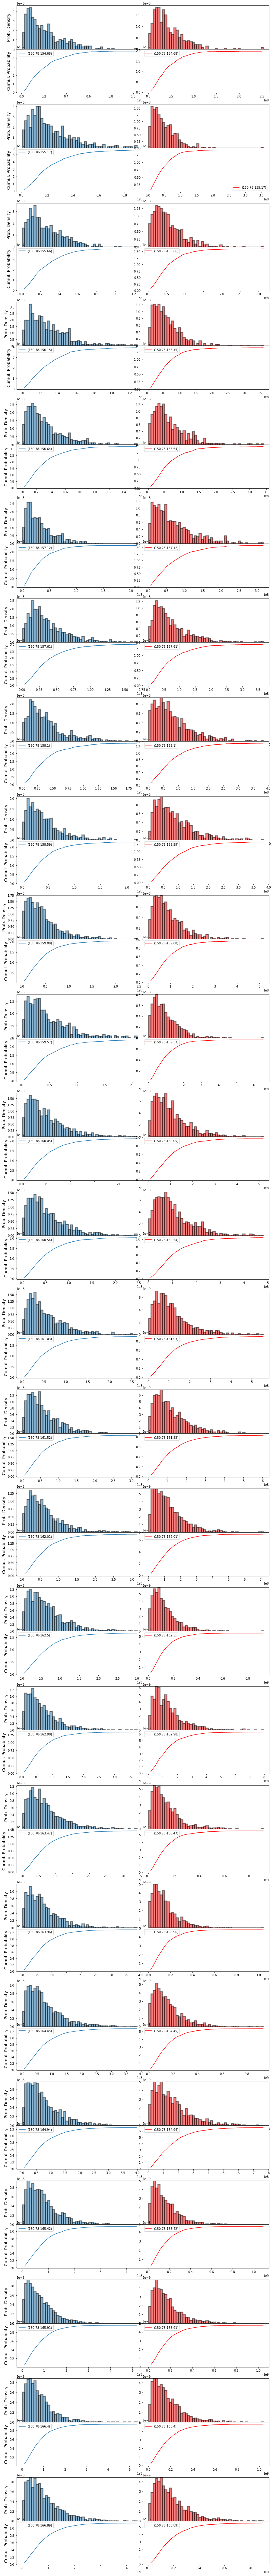

<Figure size 432x288 with 0 Axes>

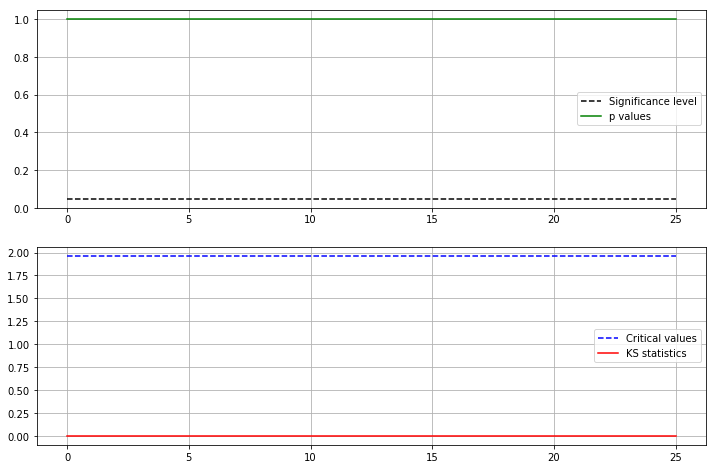

In [99]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=False)

#We will store the histogram values to plot the cdf
cdf=[]

num_rows = len(spw_range)

gs = gridspec.GridSpec(num_rows,1)
gs.update(wspace=0.2, hspace=0.13)



data_array_pspec = []
data_array_direct = []
i=0
for pspec_pwr, direct_pwr, dly_ind_rng, spw_r in zip(pspec_power, direct_power,delay_index_range, spw_range):
    
    data_pspec = pspec_pwr.T[dly_ind_rng[0]:dly_ind_rng[1],:].flatten()
    data_direct = direct_pwr.T[dly_ind_rng[0]:dly_ind_rng[1],:].flatten()
    
    data_array_pspec.append(data_pspec)
    data_array_direct.append(data_direct)

    gss01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[i],wspace=0.0,hspace=0.0)
    

    ax0 = fig.add_subplot(gss01[0])
    ax1 = fig.add_subplot(gss01[2], sharex=ax0)
    ax2 = fig.add_subplot(gss01[1])
    ax3 = fig.add_subplot(gss01[3], sharex=ax2)


    p0=ax0.hist(data_pspec,alpha=0.5,bins=50,density=True,linewidth=3,edgecolor='k',label="Pspec")
    p2=ax2.hist(data_direct,alpha=0.5,bins=50,density=True,linewidth=3,edgecolor='k',label="Direct",color='r')
    ax0.set_ylabel("Prob. Density",fontsize=14)
    ax1.set_ylabel("Cumul. Probability", fontsize=14)
    #ax00 = fig.add_subplot(gss01[0])
    #ax11 = fig.add_subplot(gss01[1], sharex=ax0)
    cdf_sum_pspec = np.cumsum(p0[0]) # calculate the cdf
    cdf_sum_direct = np.cumsum(p2[0])
    i = i+1
    
    ax1.plot(p0[1][1:],cdf_sum_pspec,alpha=1,label=spw_r)
    ax3.plot(p2[1][1:],cdf_sum_direct,alpha=1,label=spw_r,color='r')
    ax1.legend() 
    ax3.legend() 

fig.set_size_inches(w=15,h=6*num_rows)

plt.figure()

x_pspec = np.linspace(0, len(data_array_pspec)-1, len(data_array_pspec))
plot_2datasamples_kstest(x_pspec, data_array_direct,data_array_pspec)